# **Extracting data**

### Extracting museum visitor data from wikipedia

In [15]:
import requests
import json
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('classic')
from sklearn.linear_model import LinearRegression

In [2]:
# Extract from wikipedia api
url = "https://en.wikipedia.org/w/api.php?action=parse&format=json&page=list_of_most-visited_museums&section=2&prop=text"
wiki_data_text = requests.request("GET", url).text
wiki_data_json = json.loads(wiki_data_text)
html_data = wiki_data_json["parse"]["text"]["*"]

# Parse with BeautifulSoup
# https://www.crummy.com/software/BeautifulSoup/bs4/doc/
soup = BeautifulSoup(html_data, 'html.parser')

tbody = soup.table.tbody
ls_rows = tbody.find_all(["tr"])

# Get column names
# column_name_row = ls_rows[0]
# ls_th = ls_rows[0].find_all(["th"])
# column_names = []
# for th in ls_th:
#   column_names.append(th.text)
column_names = ['Name', 'Country', 'City', 'Visitors per year', 'Year reported']

# Transform
data = []
for tr in ls_rows[1:]:
  cells = tr.find_all(["td"])

  # [0]: Name
  # Ex: <td><a href="/wiki/Louvre" title="Louvre"> Louvre </a></td>
  museum_name = cells[0].a.text
  # [1]: Country flag, city
  # Ex: <td> <span><a href="/wiki/France"><img/></a></span> <a href="/wiki/Paris" title="Paris"> Paris</a> </td>
  a_tags = cells[1].find_all(["a"])
  country = a_tags[0].attrs["href"][6:]
  country = country.replace("_", " ")
  city = a_tags[1].contents[0]
  # [2]: Visitors per year
  # Ex: <td>9,600,000</td>
  visitors = cells[2].text
  # [3]: Year reported
  year = cells[3].text
  row = [museum_name, country, city, visitors, year]

  data.append(row)

# Load in Data Frame
wiki_df = pd.DataFrame(data, columns=column_names)
wiki_df.head()

,Name,Country,City,Visitors per year,Year reported
0,Louvre,France,Paris,"9,600,000",2019[1]\n
1,National Museum of China,China,Beijing,"7,390,000",2019[1]\n
2,Vatican Museums,Vatican City,Vatican City,"6,882,931",2019[1]\n
3,Metropolitan Museum of Art,United States,New York City,"6,479,548",2019[1]\n
4,British Museum,United Kingdom,London,"6,239,983",2019[1]\n


In [3]:
# Clean data
wiki_df["Year reported"] = wiki_df["Year reported"].str[:-4]
wiki_df["Visitors per year"].astype("string")
wiki_df["Visitors per year"] = wiki_df["Visitors per year"].str.replace(",", "")
wiki_df["Visitors per year"].astype("int")

wiki_df.head()

,Name,Country,City,Visitors per year,Year reported
0,Louvre,France,Paris,9600000,2019
1,National Museum of China,China,Beijing,7390000,2019
2,Vatican Museums,Vatican City,Vatican City,6882931,2019
3,Metropolitan Museum of Art,United States,New York City,6479548,2019
4,British Museum,United Kingdom,London,6239983,2019


### Extract population data from London Database

In [4]:
# Data extractedf from London DATASTORE global city population estimates
# https://data.london.gov.uk/dataset/global-city-population-estimates

london_df = pd.read_excel("/content/global-city-population-estimates.xls", "CITIES-OVER-300K", dtype={"2020": np.int64})
london_df = london_df[["Country or area", "Urban Agglomeration", "2020"]]
london_df.rename(columns={"2020": "Population", "Urban Agglomeration": "City", "Country or area": "Country"}, inplace=True)

london_df.head()

,Country,City,Population
0,Japan,Tokyo,38323
1,India,Delhi,29347
2,China,Shanghai,27137
3,Brazil,São Paulo,22118
4,India,Mumbai (Bombay),22838


In [5]:
# List of cities in museum df
cities_df = wiki_df.drop_duplicates("City")[["Country", "City"]]

# City name aliases for London dataset
london_aliases = {
    "New York City": "New York",
    "South Korea": "Republic of Korea",
    "Suzhou": "Suzhou, Jiangsu",
    "Taiwan": "China",
    "Vatican City": "Vatican"
}

cities_df.head()

,Country,City
0,France,Paris
1,China,Beijing
2,Vatican City,Vatican City
3,United States,New York City
4,United Kingdom,London


In [6]:
# Get city population

city_ls = []
country_ls = []
pop_ls = []

for index, row in cities_df.iterrows():
  city = london_aliases[row["City"]] if row["City"] in london_aliases else row["City"]
  country = london_aliases[row["Country"]] if row["Country"] in london_aliases else row["Country"]
  city = london_df[
      (london_df["City"].str.contains(city)) & 
      (london_df["Country"].str.contains(country))
      ]
      
  if not city.empty:
      city_ls.append(row["City"])
      country_ls.append(row["Country"])
      pop = city.Population.item()
      pop = int(pop) * 1000
      pop_ls.append(pop)

# Manually add missing populations
city_ls.append("Vatican City")
country_ls.append("Holy See")
pop_ls.append(825)
city_ls.append("Oświęcim")
country_ls.append("Poland")
pop_ls.append(41143)


pop_df = pd.DataFrame({"Country": country_ls, "City": city_ls, "Population": pop_ls})
pop_df

,Country,City,Population
0,France,Paris,11271000
1,China,Beijing,24201000
2,United States,New York City,18792000
3,United Kingdom,London,10849000
4,Russia,Saint Petersburg,5019000
5,China,Shanghai,27137000
6,Spain,Madrid,6476000
7,China,Guangzhou,15174000
8,United States,"Washington, D.C.",5229000
9,China,Nanjing,8475000


In [7]:
# Create population column
full_df = wiki_df
full_df["Population"] = np.nan
for index, row in full_df.iterrows():
  city = row["City"]
  pop = pop_df.loc[pop_df["City"] == city].Population.item()
  full_df.at[index, "Population"] = pop
full_df["Population"] = full_df["Population"].astype("int")
full_df.head()

,Name,Country,City,Visitors per year,Year reported,Population
0,Louvre,France,Paris,9600000,2019,11271000
1,National Museum of China,China,Beijing,7390000,2019,24201000
2,Vatican Museums,Vatican City,Vatican City,6882931,2019,825
3,Metropolitan Museum of Art,United States,New York City,6479548,2019,18792000
4,British Museum,United Kingdom,London,6239983,2019,10849000


# **Data Analysis**

In [148]:
# Removed useless columns for training_df
training_df = full_df[["City", "Visitors per year", "Population"]]
training_df.head()

,City,Visitors per year,Population
0,Paris,9600000,11271000
1,Beijing,7390000,24201000
2,Vatican City,6882931,825
3,New York City,6479548,18792000
4,London,6239983,10849000


In [149]:
# Take average visitors for cities with multiple museums
city_ls = training_df["City"].unique()
pop_ls = []
avg_ls = []

for city in city_ls:
  city_df = training_df.loc[training_df["City"] == city]
  avg_visitors = city_df["Visitors per year"].astype("int").mean()
  pop = city_df["Population"].astype("int").mean()
  pop_ls.append(pop)
  avg_ls.append(avg_visitors)

avg_df = pd.DataFrame({"City": city_ls, "Population": pop_ls, "Average Visitors": avg_ls})
avg_df.head()

,City,Population,Average Visitors
0,Paris,11271000.0,4.723871e+06
1,Beijing,24201000.0,5.050333e+06
2,Vatican City,825.0,6.882931e+06
3,New York City,18792000.0,5.739774e+06
4,London,10849000.0,4.588505e+06


Text(0.5, 1.0, 'Average Visitors')

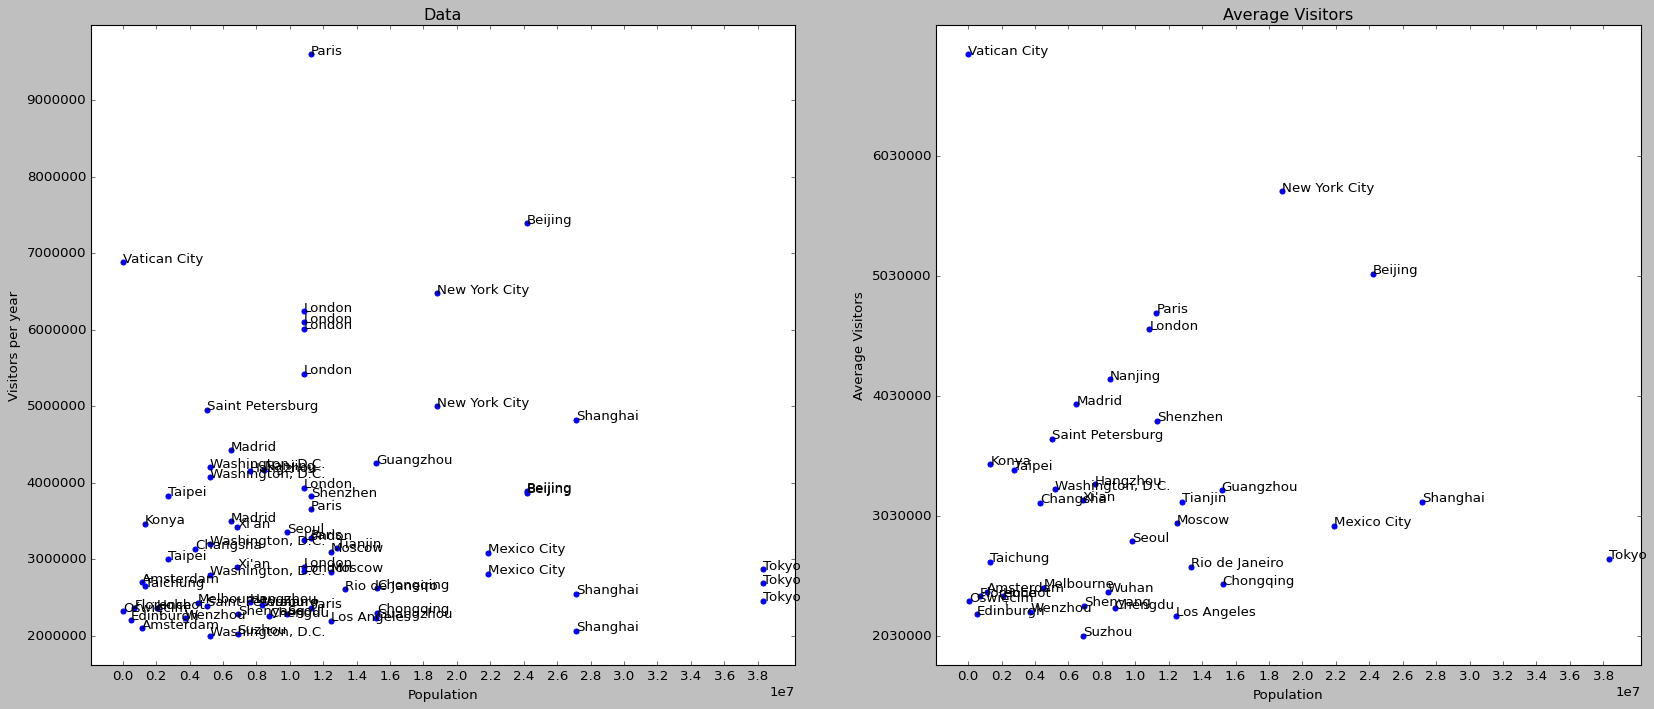

In [150]:
# Init plots
scatter_fig, (ax1, ax2) = plt.subplots(1, 2)
scatter_fig.set_figwidth(25)
scatter_fig.set_figheight(10)

# Scatter plot for training_df

og_x = training_df["Population"].astype("int")
og_y = training_df["Visitors per year"].astype("int")
og_cities = training_df["City"]

ax1.set_yticks(np.arange(og_y.min(), og_y.max(), 1000000))
ax1.set_xticks(np.arange(og_x.min(), og_x.max(), 2000000))

ax1.scatter(og_x, og_y, color='b')
for index, row in training_df.iterrows():
  ax1.annotate(row["City"], (og_x[index], og_y[index]))

ax1.set_xlabel("Population")
ax1.set_ylabel("Visitors per year")
ax1.set_title("Data")


# Scatter plot for average df

avg_x = avg_df["Population"].astype("int")
avg_y = avg_df["Average Visitors"].astype("int")
avg_cities = avg_df["City"]

ax2.set_yticks(np.arange(avg_y.min(), avg_y.max(), 1000000))
ax2.set_xticks(np.arange(avg_x.min(), avg_x.max(), 2000000))

ax2.scatter(avg_x, avg_y, color='b')
for index, row in avg_df.iterrows():
  ax2.annotate(row["City"], (avg_x[index], avg_y[index]))

ax2.set_xlabel("Population")
ax2.set_ylabel("Average Visitors")
ax2.set_title("Average Visitors")

Text(0.5, 0, 'Cities')

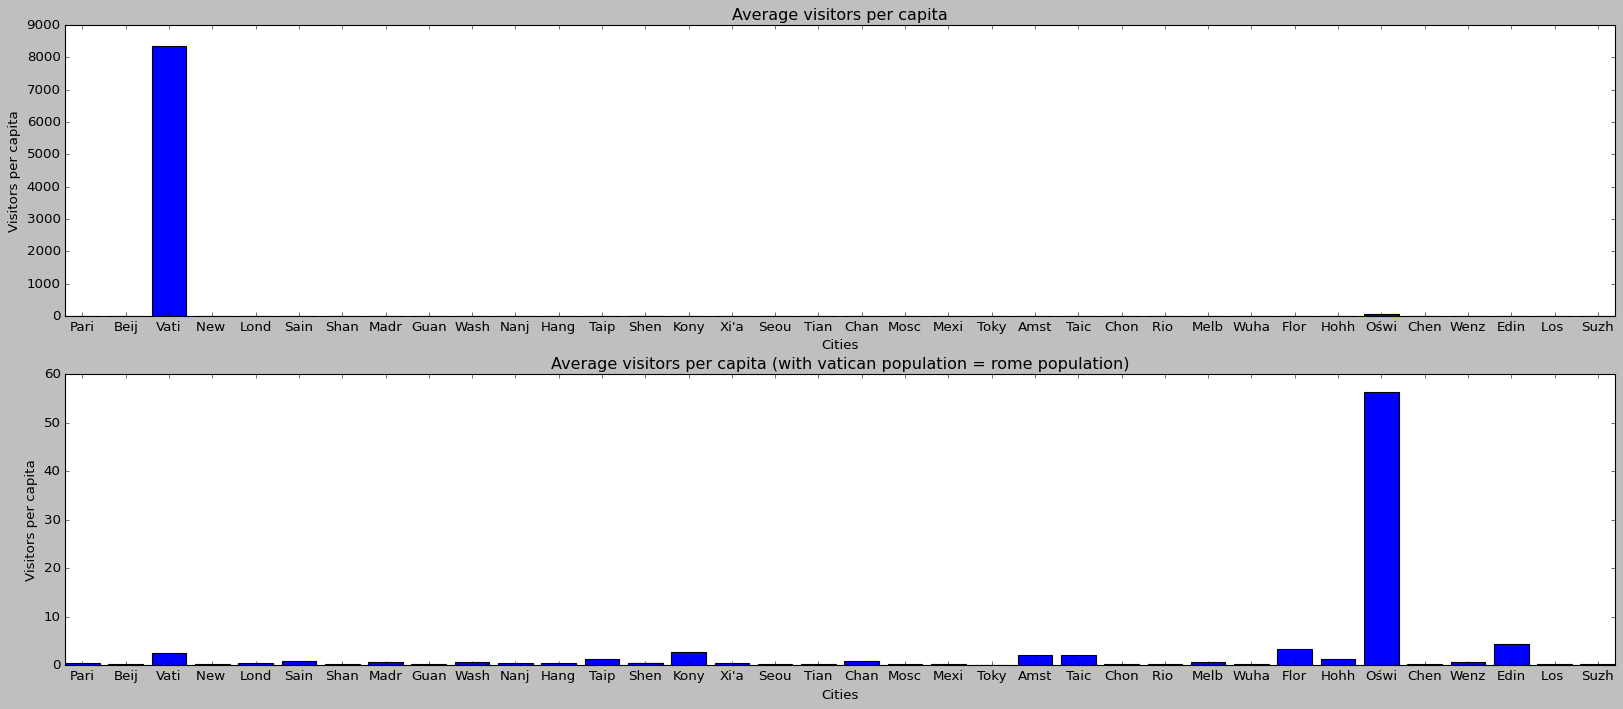

In [151]:
# Init plots
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_figwidth(25)
fig.set_figheight(10)

# Average visitor per capita data
pop = avg_df["Population"].astype("float")
avg_vis = avg_df["Average Visitors"].astype("float")
cities = avg_df["City"].str[:4]
vis_per_cap = avg_vis / pop

# Plot
ax1.bar(cities, height=vis_per_cap)
ax1.set_title("Average visitors per capita")
ax1.set_ylabel("Visitors per capita")
ax1.set_xlabel("Cities")

# With vatican population = rome population
pop = avg_df["Population"].astype("float")
avg_vis = avg_df["Average Visitors"].astype("float")
cities = avg_df["City"].str[:4]
pop.loc[2] = 2.873 * 1000000 # Vatican population = Rome population = 2.873 mil
vis_per_cap = avg_vis / pop

# Plot
ax2.bar(cities, height=vis_per_cap)
ax2.set_title("Average visitors per capita (with vatican population = rome population)")
ax2.set_ylabel("Visitors per capita")
ax2.set_xlabel("Cities")

# **Linear Regression**

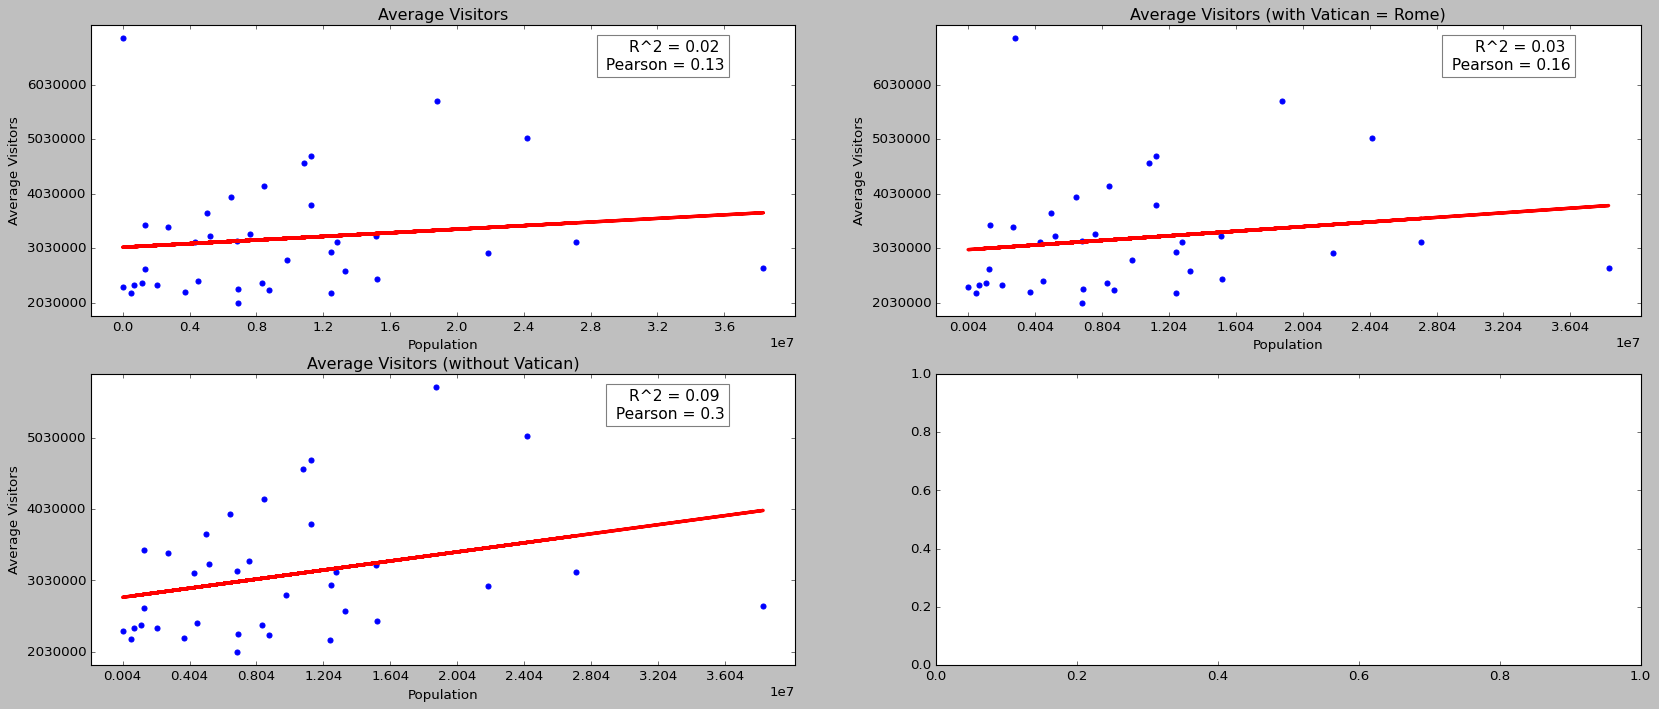

In [193]:
### AVERAGE VISITORS
def average_visitors_plot(ax):
  # Data
  x = avg_df["Population"].astype("int")
  y = avg_df["Average Visitors"].astype("int")
  cities = avg_df["City"]

  # Model
  model = LinearRegression()
  reg_x = x.values.reshape(-1, 1)
  reg_y = y.values.reshape(-1, 1)
  model.fit(reg_x, reg_y)

  # 
  p_corr = np.round(np.corrcoef(x, y)[0][1], decimals=2)
  rsquared = np.round(model.score(reg_x, reg_y), decimals=2)

  # Plot
  ax.set_yticks(np.arange(y.min(), y.max(), 1000000))
  ax.set_xticks(np.arange(x.min(), x.max(), 4000000))

  ax.scatter(x, y, color='b')
  ax.plot(reg_x, model.predict(reg_x), color="r", linewidth=3)

  ax.set_xlabel("Population")
  ax.set_ylabel("Average Visitors")
  ax.set_title("Average Visitors")

  textstr = "R^2 = {} \n Pearson = {}".format(rsquared, p_corr)
  props = dict(boxstyle='square', facecolor='white', alpha=0.5)
  ax.text(0.90, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        horizontalalignment='right', verticalalignment='top', bbox=props)


### AVERAGE VISITORS (+ VATICAN POPULATION = ROME POPULATION)
def average_visitors_with_vatican_rome(ax):
  # Data
  x = avg_df["Population"].astype("int")
  y = avg_df["Average Visitors"].astype("int")
  cities = avg_df["City"]

  x[2] = 2.873 * 1000000 # Vatican population = Rome population = 2.873 mil
  cities[2] = "Rome"

  # Model
  model = LinearRegression()
  reg_x = x.values.reshape(-1, 1)
  reg_y = y.values.reshape(-1, 1)
  model.fit(reg_x, reg_y)

  # 
  p_corr = np.round(np.corrcoef(x, y)[0][1], decimals=2)
  rsquared = np.round(model.score(reg_x, reg_y), decimals=2)

  # Plot
  ax.set_yticks(np.arange(y.min(), y.max(), 1000000))
  ax.set_xticks(np.arange(x.min(), x.max(), 4000000))

  ax.scatter(x, y, color='b')
  ax.plot(reg_x, model.predict(reg_x), color="r", linewidth=3)

  ax.set_xlabel("Population")
  ax.set_ylabel("Average Visitors")
  ax.set_title("Average Visitors (with Vatican = Rome)")

  textstr = "R^2 = {} \n Pearson = {}".format(rsquared, p_corr)
  props = dict(boxstyle='square', facecolor='white', alpha=0.5)
  ax.text(0.90, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        horizontalalignment='right', verticalalignment='top', bbox=props)


### AVERAGE VISITORS (- VATICAN)
def average_visitors_without_vatican_plot(ax):
  # Data
  x = avg_df["Population"].astype("int")
  y = avg_df["Average Visitors"].astype("int")
  cities = avg_df["City"]

  x.pop(2)
  y.pop(2)
  cities.pop(2)

  # Model
  model = LinearRegression()
  reg_x = x.values.reshape(-1, 1)
  reg_y = y.values.reshape(-1, 1)
  model.fit(reg_x, reg_y)
  
  # 
  p_corr = np.round(np.corrcoef(x, y)[0][1], decimals=2)
  rsquared = np.round(model.score(reg_x, reg_y), decimals=2)

  # Plot
  ax.set_yticks(np.arange(y.min(), y.max(), 1000000))
  ax.set_xticks(np.arange(x.min(), x.max(), 4000000))

  ax.scatter(x, y, color='b')
  ax.plot(reg_x, model.predict(reg_x), color="r", linewidth=3)

  ax.set_xlabel("Population")
  ax.set_ylabel("Average Visitors")
  ax.set_title("Average Visitors (without Vatican)")

  textstr = "R^2 = {} \n Pearson = {}".format(rsquared, p_corr)
  props = dict(boxstyle='square', facecolor='white', alpha=0.5)
  ax.text(0.90, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        horizontalalignment='right', verticalalignment='top', bbox=props)



# Init plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_figwidth(25)
fig.set_figheight(10)
average_visitors_plot(ax1)
average_visitors_with_vatican_rome(ax2)
average_visitors_without_vatican_plot(ax3)


# Removed

In [ ]:
# Opendatasoft World Cities Population dataset
# https://public.opendatasoft.com/explore/dataset/worldcitiespop/table/?disjunctive.country&sort=population

# def get_ops_pop(city):
#   url = "https://public.opendatasoft.com/api/records/1.0/search/?dataset=worldcitiespop&q={}&sort=population&facet=population".format(city)
#   data_str = requests.request("GET", url).text
#   data_json = json.loads(data_str)
#   try:
#     return data_json["records"][0]["fields"]["population"]
#   except:
#     return np.nan

# print(get_ops_pop("Oswiecim"))

In [ ]:
# https://datahub.io/core/population-city
# pop_df = pd.read_csv("/unsd-citypopulation-year-both.txt")
# pop_df.drop(["Area", "Sex", "Record Type", "Reliability", "Value Footnotes", "Source Year"], axis=1, inplace=True)
# pop_df["City"] = pop_df["City"].str.upper()
# pop_df.head()


# def get_un_pop(aliases):
#   for alias in aliases:
#     city_df = pop_df.loc[pop_df["City"] == alias]
    
#     city_urban_df = city_df.loc[city_df["City type"] == "Urban agglomeration"]
#     if not city_urban_df.empty:
#       return city_urban_df.max()["Value"]
    
#     city_proper_df = city_df.loc[city_df["City type"] == "City proper"]
#     if not city_proper_df.empty:
#       return city_proper_df.max()["Value"]
#   # No population found
#   return "nan"

# print(get_un_pop("Vatican City"))